In [58]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

dir_in = "inputs/"
csvfile = "diy.csv"

import sys
sys.path.insert(0, '../../LEARNING/tensorflow/')
sys.path.insert(0, '../../LEARNING/PCA_dl/')
from layers import full_connected
from Dataset import Dataset

In [59]:
data = pd.read_csv(dir_in+csvfile)
data.head()

,id,title,content,tags
0,1,"How do I install a new, non load bearing wall ...",<p>I'm looking to finish my basement and simpl...,remodeling basement carpentry
1,2,What kind of caulk should I use around my bath...,<p>I would like to recaulk between the bathtub...,caulking bathroom
2,3,Is fiberglass mesh tape a good choice for dryw...,<p>I'm going to be doing some drywalling short...,drywall
3,4,Are there ways to determine if a wall is load ...,"<p>Other than looking up blue prints, which ma...",walls load-bearing structural
4,5,How do I safely replace a worn out electrical ...,<p>I have a number of outlets that are old and...,repair electrical


In [60]:
nomeaning = set(['a', "a's", 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', "c'mon", "c's", 'came', 'can', "can't", 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes', 'concerning', 'consequently', 'consider', 'considering', 'contain', 'containing', 'contains', 'corresponding', 'could', "couldn't", 'course', 'currently', 'd', 'definitely', 'described', 'despite', 'did', "didn't", 'different', 'do', 'does', "doesn't", 'doing', "don't", 'done', 'down', 'downwards', 'during', 'e', 'each', 'edu', 'eg', 'eight', 'either', 'else', 'elsewhere', 'enough', 'entirely', 'especially', 'et', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'f', 'far', 'few', 'fifth', 'first', 'five', 'followed', 'following', 'follows', 'for', 'former', 'formerly', 'forth', 'four', 'from', 'further', 'furthermore', 'g', 'get', 'gets', 'getting', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'got', 'gotten', 'greetings', 'h', 'had', "hadn't", 'happens', 'hardly', 'has', "hasn't", 'have', "haven't", 'having', 'he', "he's", 'hello', 'help', 'hence', 'her', 'here', "here's", 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'hi', 'him', 'himself', 'his', 'hither', 'hopefully', 'how', 'howbeit', 'however', 'i', "i'd", "i'll", "i'm", "i've", 'ie', 'if', 'ignored', 'immediate', 'in', 'inasmuch', 'inc', 'indeed', 'indicate', 'indicated', 'indicates', 'inner', 'insofar', 'instead', 'into', 'inward', 'is', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', 'j', 'just', 'k', 'keep', 'keeps', 'kept', 'know', 'knows', 'known', 'l', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 'less', 'lest', 'let', "let's", 'like', 'liked', 'likely', 'little', 'look', 'looking', 'looks', 'ltd', 'm', 'mainly', 'many', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'merely', 'might', 'more', 'moreover', 'most', 'mostly', 'much', 'must', 'my', 'myself', 'n', 'name', 'namely', 'nd', 'near', 'nearly', 'necessary', 'need', 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nor', 'normally', 'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'p', 'particular', 'particularly', 'per', 'perhaps', 'placed', 'please', 'plus', 'possible', 'presumably', 'probably', 'provides', 'q', 'que', 'quite', 'qv', 'r', 'rather', 'rd', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'relatively', 'respectively', 'right', 's', 'said', 'same', 'saw', 'say', 'saying', 'says', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'she', 'should', "shouldn't", 'since', 'six', 'so', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'sorry', 'specified', 'specify', 'specifying', 'still', 'sub', 'such', 'sup', 'sure', 't', "t's", 'take', 'taken', 'tell', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that', "that's", 'thats', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', "there's", 'thereafter', 'thereby', 'therefore', 'therein', 'theres', 'thereupon', 'these', 'they', "they'd", "they'll", "they're", "they've", 'think', 'third', 'this', 'thorough', 'thoroughly', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'twice', 'two', 'u', 'un', 'under', 'unfortunately', 'unless', 'unlikely', 'until', 'unto', 'up', 'upon', 'us', 'use', 'used', 'useful', 'uses', 'using', 'usually', 'uucp', 'v', 'value', 'various', 'very', 'via', 'viz', 'vs', 'w', 'want', 'wants', 'was', "wasn't", 'way', 'we', "we'd", "we'll", "we're", "we've", 'welcome', 'well', 'went', 'were', "weren't", 'what', "what's", 'whatever', 'when', 'whence', 'whenever', 'where', "where's", 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', "who's", 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'willing', 'wish', 'with', 'within', 'without', "won't", 'wonder', 'would', 'would', "wouldn't", 'x', 'y', 'yes', 'yet', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves', 'z', 'zero', ''])
def Tokenizer(stringlst):
    idx = 1
    worddic = dict()
    for phrase in stringlst:
        for word in phrase:
            if word not in worddic:
                if word not in nomeaning:
                    worddic[word] = idx
                    idx += 1
    return worddic

def phrase2seq(phrase, worddic):
    words = phrase.split()
    seq = []
    for word in words:
        if word in nomeaning:
            seq.append(0)
        else:
            seq.append(worddic[word])
    return seq

def flat(hierachy):
    l = []
    for sublst in hierachy:
        for item in sublst:
            l.append(item)
    return l

def topNclose(connect, tag, N):
    taglink   = [item[1] for item in connect if item[0] == tag]
    tagweight = [item[2] for item in connect if item[0] == tag]
    
    sortedindex = np.argsort(tagweight)
    return [taglink[sortedindex[-i]] for i in xrange(N)]

In [61]:
tagslist = data.tags.apply(lambda s: s.split()).get_values()
tagdict = Tokenizer(tagslist)

m = -99
tagsindex = dict()
for key in tagdict.keys():
    if tagdict[key] > m:
        m = tagdict[key]
        tagsindex[m] = key
print("There are {} different tags.".format(m+1))


skip_gram_matrix = np.zeros((m+1, m+1))
for idx in tagsindex.keys():
    for row in tagslist:
        if tagsindex[idx] in row:
            for pair_tag in row:
                skip_gram_matrix[idx, tagdict[pair_tag]] += 1

There are 733 different tags.


## 下面網路是將一個 tag (one-hot vector) 映射到該 tag 的 co-occured tags

In [62]:
x = tf.placeholder(shape=[None, m+1], dtype=tf.float32)
y = tf.placeholder(shape=[None, m+1], dtype=tf.float32)
l1 = full_connected(x , 100, 'l1', activation='sigmoid')
l2 = full_connected(l1, 100, 'l2', activation='sigmoid')
l3 = full_connected(l2, 100, 'l3', activation='sigmoid')
out = full_connected(l3, m+1, 'out')

loss = tf.reduce_mean(tf.pow(out-y, 2))
optimizer = tf.train.RMSPropOptimizer(0.001).minimize(loss)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

dataset = Dataset(np.eye(m+1), skip_gram_matrix)
for _ in xrange(10000):
    x_batch, y_batch = dataset.next_batch(128)
    feed = {x: x_batch, y: y_batch}
    sess.run(optimizer, feed_dict=feed)
    if (_+1)%100 == 0:
        print("step {}: loss is {}".format(_+1, sess.run(loss, feed_dict={x: np.eye(m+1), y: skip_gram_matrix})))

step 100: loss is 9.79355049133
step 200: loss is 1.76154506207
step 300: loss is 0.034976914525
step 400: loss is 0.00327815394849
step 500: loss is 0.00342042860575
step 600: loss is 0.0024474398233
step 700: loss is 0.00288334698416
step 800: loss is 0.0028697210364
step 900: loss is 0.00306247849949
step 1000: loss is 0.00334659707732
step 1100: loss is 0.00250502629206
step 1200: loss is 0.00283484184183
step 1300: loss is 0.00297896517441
step 1400: loss is 0.00278833252378
step 1500: loss is 0.002401586622
step 1600: loss is 0.00291845900938
step 1700: loss is 0.00255411793478
step 1800: loss is 0.00246976083145
step 1900: loss is 0.00255869003013
step 2000: loss is 0.00266714021564
step 2100: loss is 0.00268703233451
step 2200: loss is 0.00239623291418
step 2300: loss is 0.0026294819545
step 2400: loss is 0.00250345142558
step 2500: loss is 0.00246342038736
step 2600: loss is 0.00198485422879
step 2700: loss is 0.00220776209608
step 2800: loss is 0.00208702497184
step 2900: los

In [63]:
for _ in xrange(500):
    x_batch, y_batch = dataset.next_batch(512)
    feed = {x: x_batch, y: y_batch}
    sess.run(optimizer, feed_dict=feed)
    if (_+1)%100 == 0:
        print("step {}: loss is {}".format(_+1, sess.run(loss, feed_dict={x: np.eye(m+1), y: skip_gram_matrix})))

step 100: loss is 0.0014939311659
step 200: loss is 0.0013946701074
step 300: loss is 0.00154072151054
step 400: loss is 0.00145264959428
step 500: loss is 0.00142407999374


In [64]:
tagvec = sess.run(l2, feed_dict={x: np.eye(m+1), y: skip_gram_matrix})

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(tagvec)
compressed = pca.transform(tagvec)

(-0.0005, 0.0015)

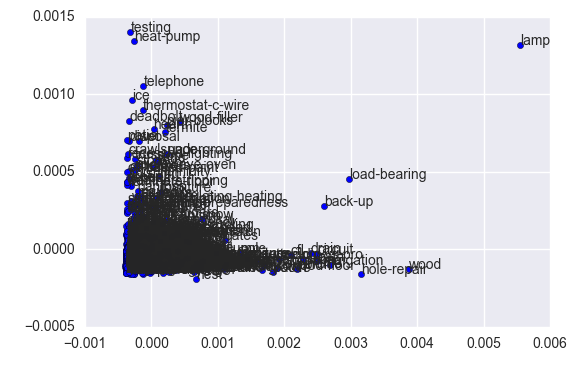

In [77]:
fig, ax = plt.subplots()
ax.scatter(compressed[:,0], compressed[:,1])

for i, txt in enumerate(tagdict.keys()):
    ax.annotate(txt, (compressed[i,0], compressed[i,1]))
    
ax.set_xlim(-0.001, 0.006)
ax.set_ylim(-0.0005, 0.0015)

In [ ]:
def tag_distance(connection, tagA, tagB, level=0):
    
    linktag = connection[connection.A==tagA].B.get_values()
    disttag = connection[connection.A==tagA].distance.get_values()
    
    for i in xrange(len(linktag)):
        if tagB == linktag[i]:
            return disttag[i]
        
    if level < 1:
        return np.min(disttag + [tag_distance(connection, tag, tagB, level+1) for tag in linktag])
    else:
        return np.inf